## Load Data


In [ ]:
!pip install -U torchtext==0.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Operation cancelled by user


In [ ]:
import torch
from torchtext import data
from torchtext.data import Field
from torchtext import vocab

In [ ]:
TEXT = data.Field()
LABEL = data.LabelField()
fields = [('text', TEXT), ('label', LABEL)]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_data, valid_data, test_data = data.TabularDataset.splits(
                                        path = '/content/drive/MyDrive/DeepLearning_2023/FP/Data/',
                                        train = 'train.csv',
                                        validation = 'validation.csv',
                                        test = 'test.csv',
                                        format = 'csv',
                                        fields = fields,
                                        skip_header = True)

In [ ]:
print(vars(train_data[0]))
print(vars(valid_data[0]))
print(vars(test_data[0]))

{'text': ['You', 'poop', 'into', 'my', 'butt,', 'then', 'I', 'poop', 'it', 'back', 'into', 'your', 'butt...'], 'label': 'NEUTRAL'}
{'text': ['I', 'never', 'win', 'raffles.', 'But', 'I', 'won', 'the', 'raffle', 'Dulce', 'for', 'the', 'Culture', 'Crawl!', 'What', 'did', 'I', 'win?', 'A', 'tie', 'and', 'a', 'pocketsquare!', 'No', '$700', 'handbag', 'for', 'me'], 'label': 'SURPRISE'}
{'text': ['About', 'to', 'go', 'shoot', 'guns', 'and', 'be', 'angry', 'and', 'stuff.'], 'label': 'ANGER'}


160459


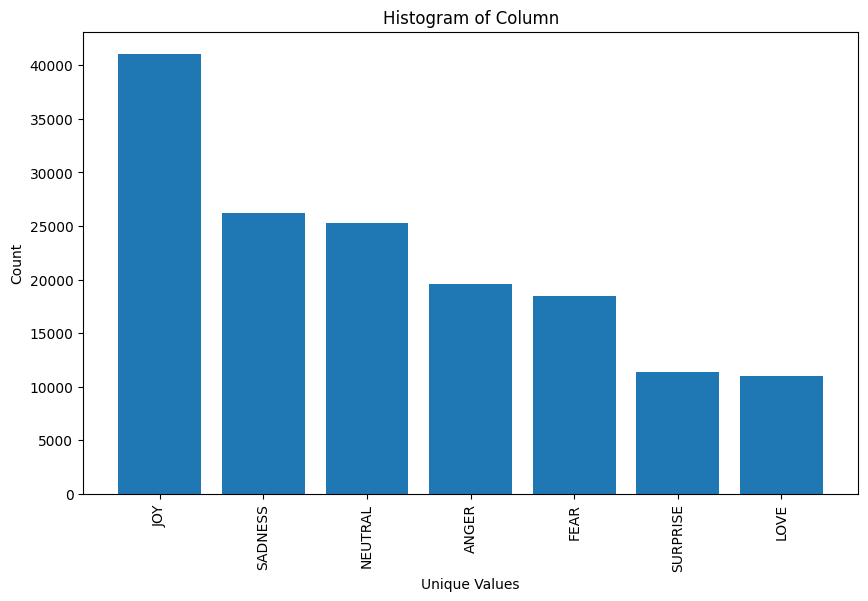

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Read the CSV file
df = pd.read_csv('/content/drive/MyDrive/DeepLearning_2023/FP/Data/train.csv')
print(len(df))
# Count occurrences of values in a column
value_counts = df['label'].value_counts()

# Create a histogram
plt.figure(figsize=(10, 6))
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Histogram of Column')
plt.xticks(rotation=90)
plt.show()

## Build Vocabulary


In [ ]:
MAX_VOCAB_SIZE = 400_000

TEXT.build_vocab(train_data,
                 max_size = MAX_VOCAB_SIZE,
                 vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_)

In [ ]:
LABEL.build_vocab(train_data)
print(LABEL.vocab.stoi)

defaultdict(None, {'JOY': 0, 'SADNESS': 1, 'NEUTRAL': 2, 'ANGER': 3, 'FEAR': 4, 'SURPRISE': 5, 'LOVE': 6, '': 7})


In [ ]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device, sort=False)

## CNN Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim,
                 dropout, pad_idx):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1,
                                              out_channels = n_filters,
                                              kernel_size = (fs, embedding_dim))
                                    for fs in filter_sizes
                                    ])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        #text = [sent len, batch size]
        text = text.permute(1, 0)   #text = [batch size, sent len]

        embedded = self.embedding(text)   #embedded = [batch size, sent len, emb dim]

        embedded = embedded.unsqueeze(1)  #embedded = [batch size, 1, sent len, emb dim]

        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]   #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]

        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]  #pooled_n = [batch size, n_filters]

        cat = self.dropout(torch.cat(pooled, dim = 1))  #cat = [batch size, n_filters * len(filter_sizes)]

        return self.fc(cat)

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS =  100
FILTER_SIZES = [2,3,4]
OUTPUT_DIM = len(LABEL.vocab)
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 12,004,408 trainable parameters


In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.0666, -0.4321, -1.7954,  ...,  0.7594,  0.0864, -2.1693],
        [ 0.2055, -1.2503, -2.4588,  ..., -0.4954, -1.0296,  0.9323],
        [-0.0465,  0.6197,  0.5665,  ..., -0.3762, -0.0325,  0.8062],
        ...,
        [-0.1943, -1.4096, -0.8231,  ...,  0.8888,  0.3909, -1.3662],
        [-0.6558, -1.0776,  1.4807,  ...,  0.3185, -1.0372,  1.5821],
        [ 1.3119, -0.4598,  1.3550,  ..., -0.3871, -3.1271,  0.4795]])

In [ ]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

### Functions


In [ ]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for batch in iterator:
        optimizer.zero_grad()
        predictions = model(batch.text)
        loss = criterion(predictions, batch.label)
        acc = categorical_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for batch in iterator:

            predictions = model(batch.text)

            loss = criterion(predictions, batch.label)

            acc = categorical_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Train the model

In [ ]:
N_EPOCHS = 15

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

## Test model

In [ ]:
plt.plot(train_loss, linewidth=3.0, label='Test_acc')
plt.xlabel('Train step', fontsize=14)
plt.ylabel('Accuracy(%)', fontsize=14)

plt.title("Accuracy for Improved Implementation")
plt.legend()
plt.show()

In [ ]:
model.load_state_dict(torch.load('tut5-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

## Predictions


In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

def predict_class(model, sentence, min_len = 4):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    preds = model(tensor)
    max_preds = preds.argmax(dim = 1)
    return max_preds.item()

In [ ]:
pred_class = predict_class(model, "im frustrated with the ending")
print(f'Predicted class is: {pred_class} = {LABEL.vocab.itos[pred_class]}')

In [ ]:
pred_class = predict_class(model, "i have been disapointed by this movie")
print(f'Predicted class is: {pred_class} = {LABEL.vocab.itos[pred_class]}')

In [ ]:
pred_class = predict_class(model, "what an unexpected scene")
print(f'Predicted class is: {pred_class} = {LABEL.vocab.itos[pred_class]}')

In [ ]:
pred_class = predict_class(model, "im really hungry")
print(f'Predicted class is: {pred_class} = {LABEL.vocab.itos[pred_class]}')

In [ ]:
pred_class = predict_class(model, "i dont understand anything i think im gonna cry")
print(f'Predicted class is: {pred_class} = {LABEL.vocab.itos[pred_class]}')